In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os
from analysisUtils import getProcessingResults, getResults, getMonitorData, getQueue, getLatency

In [2]:
path = './results/'
msgsPerFile = 1

df = getResults(path, msgsPerFile)

### Do more nodes mean more messages processed?

# Number of messages sent and processed
ports = [1,2,3,4,5,6]
for i in ports:    
    df1 = df[(df['port']==i) & (df['execMem']=='2g') & (df['version']==0) & (df['time']==300000)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
    df1.plot.bar(x='nodes')
    f = plt.gcf()
    plt.title(str(i)+' Producer'+('s' if i>1 else ''), color='black')
    plt.legend(['Processed Messages', 'Sent Messages'], loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    plt.xlabel('number of executor nodes')    
    f.savefig('graphs/'+str(i)+'port_allnodes_output.pdf',bbox_inches='tight')



ValueError: invalid literal for int() with base 10: '.DS'

In [ ]:
# Resources Used
# node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
node = ['slave1', 'slave2','slave3','slave4','slave5','slave6']
# CPU %
for producer in range(1,7):
    dfResults = pd.DataFrame({})
    for i in range(1,7):
        path = 'results/'+str(i)+'_'+str(producer)+'_300000_2g_1_'
        filterList = node[:node.index('slave'+str(i))+1]
        dfTemp = pd.DataFrame({})
        for j in filterList:
            df = getMonitorData(path, j)
            dfTemp[j] = [df.filter(items=['cpu']).mean()['cpu']]
        dfResults = pd.concat([dfResults, dfTemp], sort=False)
    nodes = [1,2,3,4,5,6]
    dfResults['nodes'] = nodes 
    dfResults.plot.bar(x='nodes')
    f = plt.gcf()
    plt.title('Average CPU usage(%) in with '+str(producer)+' producer'+('s' if producer>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('CPU %')
    plt.xlabel('number of executor nodes')
    f.savefig('graphs/'+str(producer)+'producer_cpu.pdf',bbox_inches='tight')



In [ ]:
# MEM %
for producer in range(1,7):
    dfResults = pd.DataFrame({})
    for i in range(1,7):
        path = 'results/'+str(i)+'_'+str(producer)+'_300000_2g_1_'
        filterList = node[:node.index('slave'+str(i))+1]
        dfTemp = pd.DataFrame({})
        for j in filterList:
            df = getMonitorData(path, j)
            dfTemp[j] = [df.filter(items=['mem']).mean()['mem']]
        dfResults = pd.concat([dfResults, dfTemp], sort=False)
    nodes = [1,2,3,4,5,6]
    dfResults['nodes'] = nodes 
    dfResults.plot.bar(x='nodes')
    f = plt.gcf()
    plt.title('Average Memory usage(%) in with '+str(producer)+' producer'+('s' if producer>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('Memory %')
    plt.xlabel('number of executor nodes')
    f.savefig('graphs/'+str(producer)+'producer_mem.pdf',bbox_inches='tight')


In [ ]:
# Latency Calculation
nodes = ['1 node', '2 nodes', '3 nodes', '4 nodes', '5 nodes', '6 nodes']

for producer in range(1,7):
    avgLatency = []
    for node in range(1,7):
        path = 'results/'+str(node)+'_'+str(producer)+'_300000_2g_1_'
        avgLatency.append(getLatency(path))
    df = pd.DataFrame({'nodes':nodes, 'latency':avgLatency})
    df.dropna().plot.bar(x='nodes')
    f = plt.gcf()
    plt.title('Average latency with ' + str(producer) + ' producer' + ('s' if producer>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('seconds')
    plt.xlabel('')
    f.savefig('graphs/'+str(producer)+'producer_latency.pdf',bbox_inches='tight')


In [ ]:
# Message Queue size
for producer in range(1,7):
    path = 'results/1_'+str(producer)+'_300000_2g_1_'
    dfConcat = getQueue(path)
    dfConcat = dfConcat.rename(columns={'queue':'1 node'})
    for node in range(2,7):
        path = 'results/'+str(node)+'_'+str(producer)+'_300000_2g_1_'
        df = getQueue(path)
        dfConcat = pd.merge_ordered(dfConcat,df,on='time',fill_method='ffill').fillna(0)
        dfConcat = dfConcat.rename(columns={'queue':str(node)+' node'+('s' if node>1 else '')})

    dfConcat['time'] = dfConcat['time']*10**(-9)
    dfConcat.plot(x='time')
    f = plt.gcf()
    plt.title('Message queue with ' + str(producer) + ' producer' + ('s' if producer>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    f.savefig('graphs/'+str(producer)+'producer_queue.pdf',bbox_inches='tight')

In [ ]:
path = './results/'
msgsPerFile = 1

df = getResults(path, msgsPerFile)

# 1 nodes
f = plt.figure()
df1 = df[(df['nodes']==1) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('1 Executor Node', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/1nodes_allports_output.pdf',bbox_inches='tight')

# 2 nodes
f = plt.figure()
df1 = df[(df['nodes']==2) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('2 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/2nodes_allports_output.pdf',bbox_inches='tight')

# 3 nodes
f = plt.figure()
df1 = df[(df['nodes']==3) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('3 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/3nodes_allports_output.pdf',bbox_inches='tight')

# 4 nodes
f = plt.figure()
df1 = df[(df['nodes']==4) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('4 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/4nodes_allports_output.pdf',bbox_inches='tight')

# 5 nodes
f = plt.figure()
df1 = df[(df['nodes']==5) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('5 Executor Nodes', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/5nodes_allports_output.pdf',bbox_inches='tight')

# 6 nodes
f = plt.figure()
df1 = df[(df['nodes']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')
f = plt.gcf()
plt.title('6 Executor Nodes', color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/6nodes_allports_output.pdf',bbox_inches='tight')

In [ ]:
# Post Mortem Results - Scaling out

lst = [1,2,3,4,5,6]

for nodes in lst: 
    path = './results/'
    msgsPerFile = 1
    df = getResults(path, msgsPerFile)

    f = plt.figure()
    df1 = df[(df['nodes']==nodes) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
    df1.plot.bar(x='port')
    f = plt.gcf()
    plt.title(str(nodes)+' Executor Node'+('s' if nodes>1 else ''), color='black')
    plt.legend(['Processed Messages', 'Sent Messages'], loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    plt.xlabel('number of producers')
    f.savefig('graphs/'+str(nodes)+'nodes_allports_output.pdf',bbox_inches='tight')

    node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
    filterList = node[:node.index('slave'+str(nodes))+1]
    # CPU %
    dfResults = pd.DataFrame({'node':node})
    for i in range(1,7):
        cpu = []
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        for j in node:
            df = getMonitorData(path, j)
            cpu.append(df.filter(items=['cpu']).mean()['cpu'])
        dfResults[str(i)+' producer'+('s' if i>1 else '')] = cpu


    dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
    f = plt.gcf()
    plt.title('Average CPU usage(%) in '+str(nodes)+' executor node'+ ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('CPU %')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_cpu.pdf',bbox_inches='tight')

    # MEM %
    node = ['producer', 'master', 'slave1', 'slave2','slave3','slave4','slave5','slave6']
    dfResults = pd.DataFrame({'node':node})

    for i in range(1,7):
        mem = []
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        for j in node:
            df = getMonitorData(path, j)
            mem.append(df.filter(items=['mem']).mean()['mem'])
        dfResults[str(i)+' producers'+('s' if i>1 else '')] = mem
    dfResults[(dfResults['node'].isin(filterList))].plot.bar(x='node')
    f = plt.gcf()
    plt.title('Average memory usage(%) in '+str(nodes)+' executor node' + ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('Memory %')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_mem.pdf',bbox_inches='tight')


    # Message Queue size
    path = 'results/'+str(nodes)+'_1_300000_2g_1_'
    dfConcat = getQueue(path)
    dfConcat = dfConcat.rename(columns={'queue':'1 producer'})
    for i in range(2,7):
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        df = getQueue(path)
        dfConcat = pd.merge_ordered(dfConcat,df,on='time',fill_method='ffill').fillna(0)
        dfConcat = dfConcat.rename(columns={'queue':str(i)+' producers'})

    dfConcat['time'] = dfConcat['time']*10**(-9)
    dfConcat.plot(x='time')
    f = plt.gcf()
    plt.title('Message queue with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('number of messages')
    f.savefig('graphs/'+str(nodes)+'executornode_queue.pdf',bbox_inches='tight')

    # Latency Calculation
    producers = ['1 producer', '2 producers', '3 producers', '4 producers', '5 producers', '6 producers']
    avgLatency = []
    for i in range(1,7):
        path = 'results/'+str(nodes)+'_'+str(i)+'_300000_2g_1_'
        avgLatency.append(getLatency(path))

    df = pd.DataFrame({'producers':producers, 'latency':avgLatency})
    print(df.dropna())
    df.dropna().plot.bar(x='producers')
    f = plt.gcf()
    plt.title('Average latency with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('seconds')
    plt.xlabel('')
    f.savefig('graphs/'+str(nodes)+'executornode_latency.pdf',bbox_inches='tight')


In [ ]:
# Post Mortem Results - Scaling out

nodes = 3
ports = 5

path = './results/'
msgsPerFile = 1
df = getResults(path, msgsPerFile)

# number of messages

f = plt.figure()
df1 = df[(df['nodes']==nodes) & (df['port']==ports) & (df['version']==0) & (df['time']==300000)].sort_values(by='execMem').filter(items=['execMem','recvMsgs','sentMsgs'])
df1['execIndex'] = [int(i[:len(i)-1]) for i in df1['execMem']]
df1 = df1.sort_values(by='execIndex').filter(items=['execMem','recvMsgs','sentMsgs'])
df1.plot.bar(x='execMem')
f = plt.gcf()
plt.title(str(nodes)+' Executor Node'+('s' if nodes>1 else ''), color='black')
plt.ylabel('number of messages')
plt.xlabel('allocated memory per executor node')    
plt.legend(['Processed Messages', 'Sent Messages'], loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports_output.pdf',bbox_inches='tight')




# CPU%

node = ['slave1','slave2','slave3','slave4','slave5','slave6']
filterList = node[:node.index('slave'+str(nodes))+1]
execMem = ['2g', '4g', '8g', '12g','14g']

dfResults = pd.DataFrame({})
for i in execMem:
    cpu = []
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    dfTemp = pd.DataFrame({})
    for j in filterList:
        df = getMonitorData(path, j)
        dfTemp[j] = [df.filter(items=['cpu']).mean()['cpu']]
    dfResults = pd.concat([dfResults, dfTemp], sort=False)
dfResults['execMem'] = execMem
dfResults.plot.bar(x='execMem')

f = plt.gcf()
plt.title('Average CPU usage(%) in '+str(nodes)+' executor node'+ ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
plt.ylabel('CPU %')
plt.xlabel('memory allocated per executor node')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports_cpu.pdf',bbox_inches='tight')

# MEM%

dfResults = pd.DataFrame({})
for i in execMem:
    cpu = []
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    dfTemp = pd.DataFrame({})
    for j in filterList:
        df = getMonitorData(path, j)
        dfTemp[j] = [df.filter(items=['mem']).mean()['mem']]
    dfResults = pd.concat([dfResults, dfTemp], sort=False)
dfResults['execMem'] = execMem
dfResults.plot.bar(x='execMem')

f = plt.gcf()
plt.title('Average memory usage(%) in '+str(nodes)+' executor node'+ ('s' if nodes>1 else '') + ' Standalone Cluster', color='black')
plt.ylabel('Memory usage %')
plt.xlabel('memory allocated per executor node')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports_mem.pdf',bbox_inches='tight')


# Queue length

path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+execMem[0]+'_1_'
dfConcat = getQueue(path)
dfConcat = dfConcat.rename(columns={'queue':execMem[0]})
for i in execMem[1:]:
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    df = getQueue(path)
    dfConcat = pd.merge_ordered(dfConcat,df,on='time',fill_method='ffill').fillna(0)
    dfConcat = dfConcat.rename(columns={'queue':i})
    
dfConcat['time'] = dfConcat['time']*10**(-9)
dfConcat.plot(x='time')
f = plt.gcf()
plt.title('Message queue with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('number of messages')
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports_queue.pdf',bbox_inches='tight')


# Latency Calculation
avgLatency = []
for i in execMem:
    path = 'results/'+str(nodes)+'_'+str(ports)+'_300000_'+i+'_1_'
    avgLatency.append(getLatency(path))

df = pd.DataFrame({'execMem':execMem, 'latency':avgLatency})
print(df.dropna())
df.dropna().plot.bar(x='execMem')
f = plt.gcf()
plt.title('Average latency with ' + str(nodes) + ' executor node' + ('s' if nodes>1 else ''), color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('seconds')
plt.xlabel('')
f.savefig('graphs/'+str(nodes)+'nodes_scaling_out_'+str(ports)+'ports_latency.pdf',bbox_inches='tight')


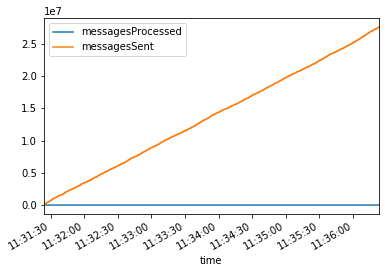

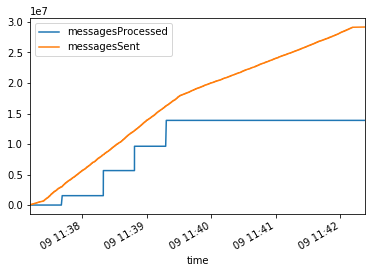

In [10]:
path = 'results/1_6_300000_2g_30_'
getProcessingResults(path).plot(x='time')
path = 'results/2_6_300000_2g_30_'
getProcessingResults(path).plot(x='time')
# path = 'results/3_6_300000_2g_30_'
# getProcessingResults(path).plot(x='time')
# path = 'results/4_6_300000_2g_30_'
# getProcessingResults(path).plot(x='time')
# path = 'results/5_6_300000_2g_30_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_6_300000_2g_30_'
# getProcessingResults(path).plot(x='time')

# # with partitions
# path = 'results/3_6_300000_2g_4_1'
# getProcessingResults(path).plot(x='time')


# path = 'results/3_6_300000_2g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/3_6_300000_4g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_6_300000_12g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_6_300000_14g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_3_300000_2g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_2_300000_2g_1_'
# getProcessingResults(path).plot(x='time')
# path = 'results/6_1_300000_2g_1_'
# getProcessingResults(path).plot(x='time')

# path = 'results/5_5_300000_14g_1_'
# getProcessingResults(path).plot(x='time')

# path = 'results/3_2_300000_12g_1_'
# getProcessingResults(path).plot(x='time')





In [ ]:
# pick a folder
path = 'results/4_4_300000_2g_1_'

df = getMonitorData(path, 'master')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave1')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave6')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

print(df.filter(items=['mem']).mean())

df.plot(y=['cpu_ma','mem_ma'])